In [ ]:
# PdsehbFugIlPbfIka62pDBcIU
# zt10Azyj05HTE8kVY5hWyUiZ0AtfEhxRObvrRmGE5H1loQo3yK

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pyLDAvis
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis
import pyLDAvis.gensim_models

# Enable pyLDAvis in notebook
pyLDAvis.enable_notebook()

In [ ]:
file_path = '/content/drive/MyDrive/data/cve/cve-processed-flattened.csv'

# Specify data types for known columns to avoid DtypeWarning
dtype_spec = {
    'cve_id': str,
    'sourceIdentifier': str,
    'published': str,
    'lastModified': str,
    'vulnStatus': str,
    'description': str,
    'metrics_cvssMetricV2_baseSeverity': str,
    'metrics_cvssMetricV2_exploitabilityScore': float,
    'metrics_cvssMetricV2_impactScore': float,
    'metrics_cvssMetricV2_cvssData.version': str,
    'metrics_cvssMetricV2_cvssData.vectorString': str,
    'metrics_cvssMetricV2_cvssData.accessVector': str,
    'metrics_cvssMetricV2_cvssData.accessComplexity': str,
    'metrics_cvssMetricV2_cvssData.authentication': str,
    'metrics_cvssMetricV2_cvssData.confidentialityImpact': str,
    'metrics_cvssMetricV2_cvssData.integrityImpact': str,
    'metrics_cvssMetricV2_cvssData.availabilityImpact': str,
    'metrics_cvssMetricV2_cvssData.baseScore': float,
    'references_url': str,
    'references_source': str,
    'published_year': int,
    'published_month': int,
    'published_day': int
}

data = pd.read_csv(file_path, dtype=dtype_spec)

# Display the first few rows
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cve_id,sourceIdentifier,published,lastModified,vulnStatus,description,metrics_cvssMetricV2_baseSeverity,metrics_cvssMetricV2_exploitabilityScore,metrics_cvssMetricV2_impactScore,metrics_cvssMetricV2_cvssData.version,...,metrics_cvssMetricV2_cvssData.authentication,metrics_cvssMetricV2_cvssData.confidentialityImpact,metrics_cvssMetricV2_cvssData.integrityImpact,metrics_cvssMetricV2_cvssData.availabilityImpact,metrics_cvssMetricV2_cvssData.baseScore,references_url,references_source,published_year,published_month,published_day
0,CVE-1999-0001,cve@mitre.org,1999-12-30 05:00:00+00:00,2010-12-16 05:00:00+00:00,Analyzed,ip_input.c in BSD-derived TCP/IP implementatio...,MEDIUM,10.0,2.9,2.0,...,NONE,NONE,NONE,PARTIAL,5.0,http://www.openbsd.org/errata23.html#tcpfix,cve@mitre.org,1999,12,30
1,CVE-1999-0001,cve@mitre.org,1999-12-30 05:00:00+00:00,2010-12-16 05:00:00+00:00,Analyzed,ip_input.c in BSD-derived TCP/IP implementatio...,MEDIUM,10.0,2.9,2.0,...,NONE,NONE,NONE,PARTIAL,5.0,http://www.osvdb.org/5707,cve@mitre.org,1999,12,30
2,CVE-1999-0002,cve@mitre.org,1998-10-12 04:00:00+00:00,2009-01-26 05:00:00+00:00,Analyzed,Buffer overflow in NFS mountd gives root acces...,HIGH,10.0,10.0,2.0,...,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,ftp://patches.sgi.com/support/free/security/ad...,cve@mitre.org,1998,10,12
3,CVE-1999-0002,cve@mitre.org,1998-10-12 04:00:00+00:00,2009-01-26 05:00:00+00:00,Analyzed,Buffer overflow in NFS mountd gives root acces...,HIGH,10.0,10.0,2.0,...,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,http://www.ciac.org/ciac/bulletins/j-006.shtml,cve@mitre.org,1998,10,12
4,CVE-1999-0002,cve@mitre.org,1998-10-12 04:00:00+00:00,2009-01-26 05:00:00+00:00,Analyzed,Buffer overflow in NFS mountd gives root acces...,HIGH,10.0,10.0,2.0,...,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,http://www.securityfocus.com/bid/121,cve@mitre.org,1998,10,12


In [ ]:
# Preprocess descriptions (convert to lowercase, remove special characters)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

data['cleaned_description'] = data['description'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Save the processed file
processed_file_path = '/content/drive/MyDrive/data/cve/cve-processed-flattened-cleaned.csv'
data.to_csv(processed_file_path, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
text_vectorized = vectorizer.fit_transform(data['cleaned_description'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


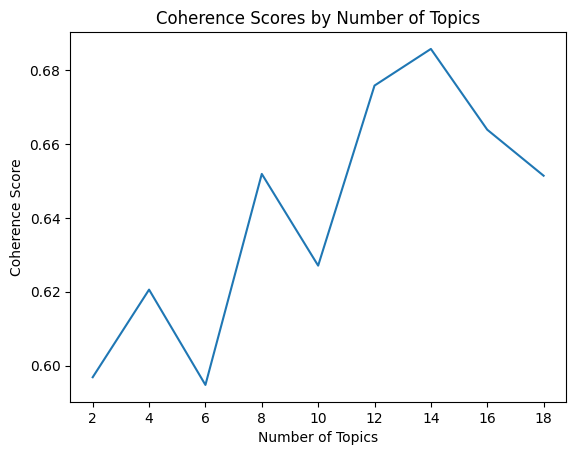

In [ ]:
# Function to compute coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        model.fit(text_vectorized)
        model_list.append(model)

        topics = []
        for topic_idx, topic in enumerate(model.components_):
            topics.append([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]])

        # Compute coherence score
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())

    return model_list, coherence_values

# Convert preprocessed text to list of words
data_words = [text.split() for text in data['cleaned_description']]

# Create Dictionary and Corpus required for coherence model
dictionary = Dictionary(data_words)
corpus = [dictionary.doc2bow(text) for text in data_words]

# Compute coherence values
start, limit, step = 2, 20, 2
model_list, coherence_values = compute_coherence_values(dictionary, corpus, data_words, limit, start, step)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

In [ ]:
# Select the model with the highest coherence score
optimal_num_topics = x[np.argmax(coherence_values)]
optimal_model = model_list[np.argmax(coherence_values)]
print(f'Optimal number of topics: {optimal_num_topics}')

Optimal number of topics: 14


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get the topic distribution for each document
topic_distribution = optimal_model.transform(text_vectorized)

# Assign the most likely topic to each document
data['dominant_topic'] = topic_distribution.argmax(axis=1)

# Save the DataFrame with the assigned topics
processed_file_with_topics_path = '/content/drive/MyDrive/data/cve/cve-processed-flattened-with-topics.csv'
data.to_csv(processed_file_with_topics_path, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from wordcloud import WordCloud

# Generate and save word clouds for each topic
for topic in range(optimal_num_topics):
    topic_words = ' '.join(data.loc[data['dominant_topic'] == topic, 'cleaned_description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    wordcloud.to_file(f'/content/drive/MyDrive/data/cve/wordcloud_topic_{topic}.png')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# prompt: lets print the unique topics,asper our results Optimal number of topics: 14

# Print the top words for each topic
for topic_idx, topic in enumerate(optimal_model.components_):
    print(f"Topic #{topic_idx}:")
    print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print()


Topic #0:
service cause denial allows attackers remote crash application os server

Topic #1:
php remote parameter code execute arbitrary file attackers url vulnerabilities

Topic #2:
sql commands execute injection arbitrary attackers parameter remote allows vulnerability

Topic #3:
script crosssite web scripting xss html remote arbitrary attackers inject

Topic #4:
information sensitive obtain jre java earlier allows attackers update remote

Topic #5:
unspecified vectors unknown vulnerability oracle attack related impact server remote

Topic #6:
code execute arbitrary overflow buffer attackers allows remote function crafted

Topic #7:
cause service denial allows crash memory attackers function remote possibly

Topic #8:
users local allows privileges gain files file linux arbitrary kernel

Topic #9:
mozilla firefox attackers remote allows seamonkey thunderbird javascript attacks conduct

Topic #10:
files directory dot remote allows attackers arbitrary traversal vulnerability read

Topi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the topic labels based on the topics
topic_labels = {
    0: "Denial of Service",
    1: "PHP Remote Execution",
    2: "SQL Injection",
    3: "Cross-site Scripting (XSS)",
    4: "Sensitive Information",
    5: "Unspecified Vulnerabilities",
    6: "Buffer Overflow",
    7: "Service Denial (Crash)",
    8: "Privilege Escalation",
    9: "Mozilla Exploits",
    10: "Directory Traversal",
    11: "Windows Vulnerabilities",
    12: "Authentication Bypass",
    13: "Multiple Overflows"
}

# Assuming you have the dominant topic already assigned in the DataFrame
# Map the numeric topic to the corresponding label
data['topic_label'] = data['dominant_topic'].map(topic_labels)

# Save the DataFrame with the topic labels
processed_file_with_labels_path = '/content/drive/MyDrive/data/cve/cve-processed-flattened-with-topic-labels.csv'
data.to_csv(processed_file_with_labels_path, index=False)

print("Data with topic labels saved successfully.")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data with topic labels saved successfully.
